In [ ]:
import os
import math
import pandas as pd
import numpy as np
import cv2
#from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
#fixing rnadom seed
np.random.seed(2019)
tf.set_random_seed(2019)
seed = 2019
IMG_SIZE=224

In [3]:
print(os.listdir('D:/Blindness Detection//2015_data'))

['resized test 15.zip', 'resized train 15.zip', 'testLabels15.csv', 'test_images', 'trainLabels15.csv', 'train_images', 'train_images_preprocessed', 'train_images_preprocessed[1, 0, 0, 0, 0]', 'train_images_preprocessed[1, 1, 0, 0, 0]', 'train_images_preprocessed[1, 1, 1, 0, 0]', 'train_images_preprocessed[1, 1, 1, 1, 0]', 'train_images_preprocessed[1, 1, 1, 1, 1]', 'train_images_preprocessed_backup']


In [4]:
df_train = pd.read_csv('D:/Blindness Detection//train.csv')
df_test = pd.read_csv('D:/Blindness Detection//test.csv')

df_train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

#### 1.2 Splitting the train data into train and validation sets.

In [5]:
id_code = df_train['id_code']
diagnosis = df_train['diagnosis']

id_code, diagnosis = shuffle(id_code, diagnosis, random_state=seed)

train_x, valid_x, train_y, valid_y = train_test_split(id_code, diagnosis, test_size=0.15, stratify=diagnosis, random_state=seed)

train_x = train_x.reset_index(drop=True)
valid_x = valid_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
valid_y = valid_y.reset_index(drop=True)


print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(df_test.shape)

(3112,)
(3112,)
(550,)
(550,)
(1928, 1)


#### 1.3 Plotting the distribution of files which belong to different classes

In [6]:
#AppliedAIcourse.com
def plot_distribution(df, labels, t_cv_te='train'):
    '''
    This function prints the distribution of output variable in a given dataframe and also prints the stats
    '''
    print('-'*80)
    class_distribution = labels.value_counts().sort_index()
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi in ' + t_cv_te + ' data')
    plt.grid()
    plt.show()

    # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    # -(class_distribution.values): the minus sign will give us in decreasing order
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/labels.shape[0]*100), 3), '%)')


--------------------------------------------------------------------------------


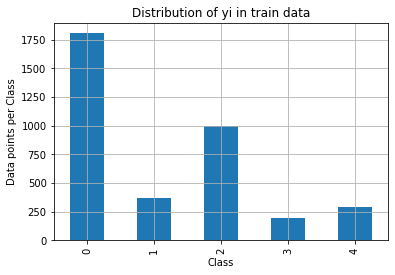

Number of data points in class 1 : 1805 ( 49.29 %)
Number of data points in class 3 : 999 ( 27.28 %)
Number of data points in class 2 : 370 ( 10.104 %)
Number of data points in class 5 : 295 ( 8.056 %)
Number of data points in class 4 : 193 ( 5.27 %)
--------------------------------------------------------------------------------


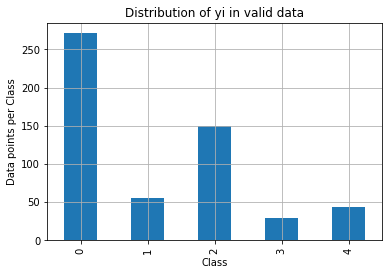

Number of data points in class 1 : 271 ( 49.273 %)
Number of data points in class 3 : 150 ( 27.273 %)
Number of data points in class 2 : 56 ( 10.182 %)
Number of data points in class 5 : 44 ( 8.0 %)
Number of data points in class 4 : 29 ( 5.273 %)


In [7]:
plot_distribution(df=df_train, labels=df_train['diagnosis'], t_cv_te='train')
plot_distribution(df=valid_x, labels=valid_y, t_cv_te='valid')

In [8]:
def image_preprocessing_1(df,labels,ben=False,sub_dir='train_images',sigmaX=10, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image to 256,256 shape and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    fig = plt.figure(figsize=(25,16))

    for class_id in sorted(labels.unique()):
        for i, (idx, row) in enumerate(df.loc[df['diagnosis']==class_id].sample(5,random_state=seed).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path="D:/Blindness Detection/"+sub_dir+'/'+row['id_code']+ext
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            if ben == True:
                #if the kernal size is [0,0] in gaussian blur then sigmaX is used for deciding the kernel size
                # https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/
                
                image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),sigmaX),-4,128)
            plt.imshow(image)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

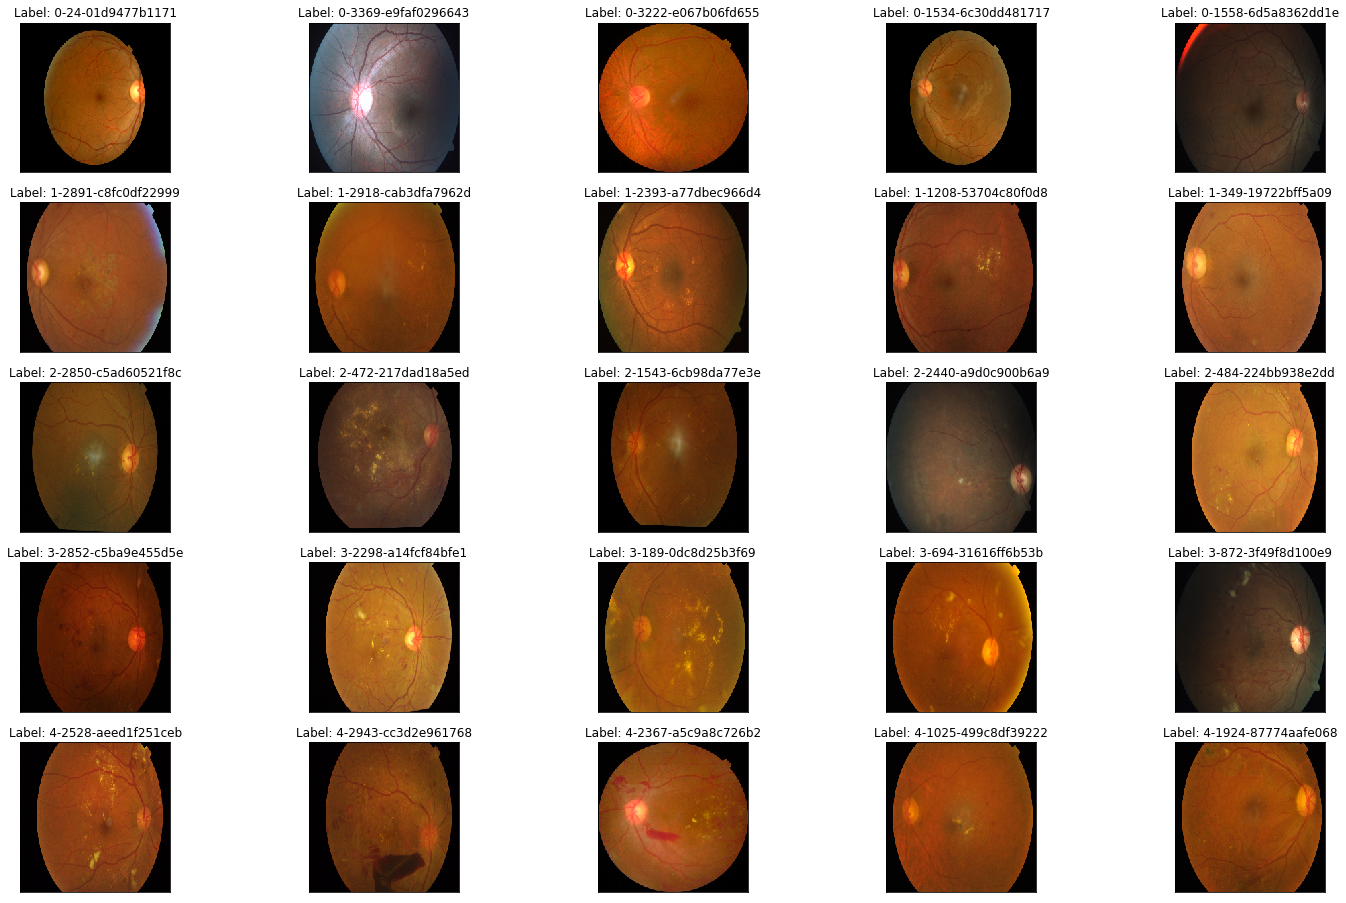

In [20]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=False,sub_dir = 'train_images')

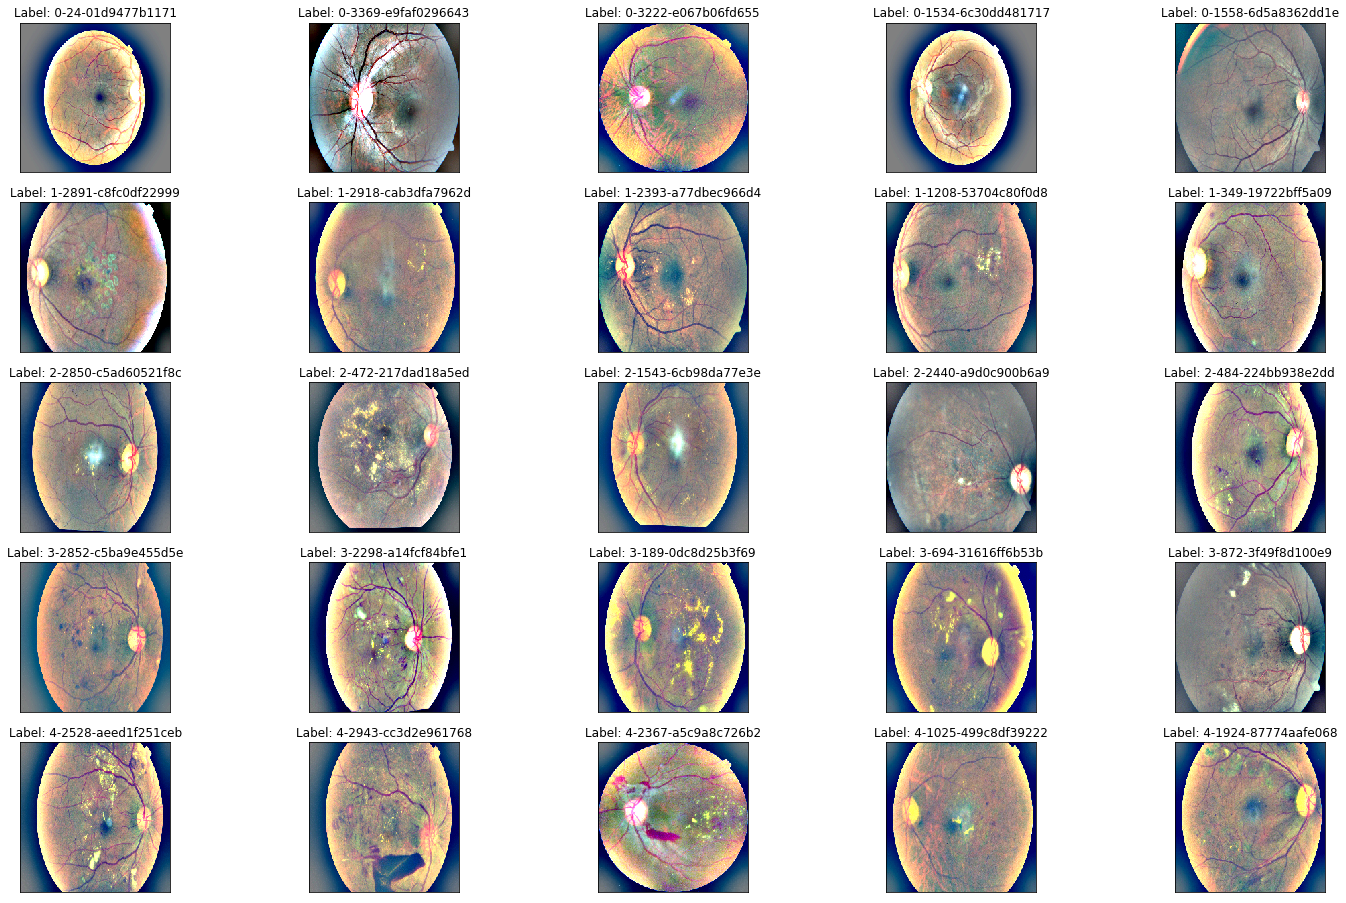

In [15]:
image_preprocessing_1(df_train,df_train['diagnosis'],ben=True,sub_dir = 'train_images',sigmaX=20)

#### From the above grids it is clear that the preprocessing has worked as the nerve,blood vessel features are visually more enhanced 

#### 1.3.2 Cropping dark edges from images

In [9]:
#https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934
def crop_dark_extras(img,tol=7):
    '''
    This function is used to crop out the additions dark areas in the images as this information is not useful
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    

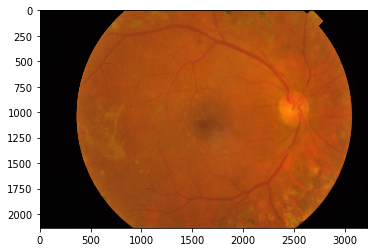

In [17]:
img = cv2.imread("D:/Blindness Detection/"+'train_images'+'/'+ df_train['id_code'][1] +'.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

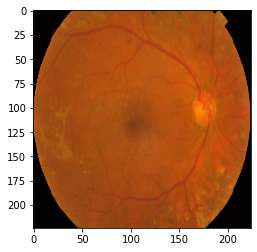

In [18]:
img = crop_dark_extras(img=img,tol=7)
img = cv2.resize(img, (224,224))
plt.imshow(img)

#### In the following cells the each image will be read from hard-disk, enchanced and also cropped, the resulting image is converted into an array representation and stored on disk 

In [8]:
def Preprocessing_images(df, sub_dir, ben=False, sigmaX=10, img_size=224, ext='.png'):
    '''
    This function reads images, converts them to RGB, resizes the image and also enhances the images/
    by blending them with gaussianBluered version of itself
    '''
    rows = df.shape[0]
    df_as_nd_array = np.empty((rows,img_size,img_size,3),dtype=np.uint8)

    for i,id_code in enumerate(tqdm(df)):
        path = "D:/Blindness Detection/"+sub_dir+'/'+ id_code + ext
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_dark_extras(img=img,tol=7)
        img = cv2.resize(img, (img_size,img_size))
        if ben == True:
            #if the kernal size is [0,0] in gaussian blur then sigmaX is used for deciding the kernel size
            # https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/
            img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),sigmaX),-4,128)
        df_as_nd_array[i,:,:,:] = img
        
    return df_as_nd_array

In [6]:
if os.path.exists('D:/Blindness Detection/x_train_224_2019.npy'):
    x_train = np.load("D:/Blindness Detection/x_train_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_train = Preprocessing_images(df=train_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_train_224_2019', arr=x_train)
                 
if os.path.exists('D:/Blindness Detection/x_valid_224_2019.npy'):
    x_valid = np.load("D:/Blindness Detection/x_valid_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_valid = Preprocessing_images(df=valid_x, sub_dir='train_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_valid_224_2019', arr=x_valid)

print(x_train.shape)
print(x_valid.shape)

(3112, 224, 224, 3)
(550, 224, 224, 3)


In [7]:
if os.path.exists('D:/Blindness Detection/x_test_224_2019.npy'):
    x_test = np.load("D:/Blindness Detection/x_test_224_2019.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
else:
    x_test = Preprocessing_images(df=df_test['id_code'], sub_dir='test_images', ben=True, sigmaX=50, img_size=IMG_SIZE)
    np.save(file='D:/Blindness Detection/x_test_224_2019', arr=x_test)

print(x_test.shape)

(1928, 224, 224, 3)


#### 1.4 Transforming Output variables.

The given output variables are categorical and this means the problem is posed as a categorical classification problem with reference to the following paper #https://arxiv.org/pdf/0704.1028.pdf it is better to trasnform such problems into ordinal regression problems.

In [8]:
#below code converts categorical outputs into onhot encoded like vectors
y_train = pd.get_dummies(train_y).values
y_valid = pd.get_dummies(valid_y).values

print(y_train.shape)
print(y_valid.shape)

(3112, 5)
(550, 5)


In [9]:
#https://arxiv.org/pdf/0704.1028.pdf
#https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets
def ordinal_regression(y):
    '''
    This function takes in the categorical(one hot encoded like) output varaible as input example [0,0,0,1,0] the output will be\
    [1,1,1,1,0] i.e all the categories before actual category are set to one
    '''
    y_multi = np.empty(y.shape, dtype=y.dtype)
    y_multi[:,4] = y[:,4] 

    for i in range(3,-1,-1):
        y_multi[:,i] = np.logical_or(y[:,i],y_multi[:,i+1])

    print(y_multi.shape)
    return y_multi

In [10]:
y_train=ordinal_regression(y_train)
y_valid=ordinal_regression(y_valid)

(3112, 5)
(550, 5)


In [11]:
#appliedaicouese.com
def plot_confusion_matrix(test_y, predict_y):
    '''
    Utility function to plot confuion matirx/ classification report, precision and recall matrices
    '''
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 5,5 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

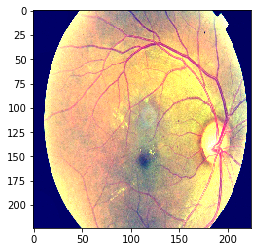

In [17]:
plt.imshow(x_train[1].reshape(IMG_SIZE,IMG_SIZE,3))

#### 2. Modelling

In [12]:
import numpy as np
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import Metric
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/CohenKappa
class CohenKappa(Metric):
    """Computes Kappa score between two raters.
    The score lies in the range [-1, 1]. A score of -1 represents
    complete disagreement between two raters whereas a score of 1
    represents complete agreement between the two raters.
    A score of 0 means agreement by chance.
    Note: As of now, this implementation considers all labels
    while calculating the Cohen's Kappa score.
    Usage:
    ```python
    actuals = np.array([4, 4, 3, 4, 2, 4, 1, 1], dtype=np.int32)
    preds = np.array([4, 4, 3, 4, 4, 2, 1, 1], dtype=np.int32)
    weights = np.array([1, 1, 2, 5, 10, 2, 3, 3], dtype=np.int32)
    m = tfa.metrics.CohenKappa(num_classes=5)
    m.update_state(actuals, preds)
    print('Final result: ', m.result().numpy()) # Result: 0.61904764
    # To use this with weights, sample_weight argument can be used.
    m = tfa.metrics.CohenKappa(num_classes=5)
    m.update_state(actuals, preds, sample_weight=weights)
    print('Final result: ', m.result().numpy()) # Result: 0.37209308
    ```
    Usage with tf.keras API:
    ```python
    model = tf.keras.models.Model(inputs, outputs)
    model.add_metric(tfa.metrics.CohenKappa(num_classes=5)(outputs))
    model.compile('sgd', loss='mse')
    ```
    """

    def __init__(self,
                 num_classes,
                 name='cohen_kappa',
                 weightage=None,
                 dtype=None):
        """Creates a `CohenKappa` instance.
        Args:
          num_classes: Number of unique classes in your dataset.
          name: (Optional) String name of the metric instance.
          weightage: (Optional) Weighting to be considered for calculating
            kappa statistics. A valid value is one of
            [None, 'linear', 'quadratic']. Defaults to `None`.
          dtype: (Optional) Data type of the metric result.
            Defaults to `None`.
        Raises:
          ValueError: If the value passed for `weightage` is invalid
            i.e. not any one of [None, 'linear', 'quadratic']
        """
        super(CohenKappa, self).__init__(name=name, dtype=tf.int64)


        self.weightage = weightage
        self.num_classes = num_classes


    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix condition statistics.
        Args:
          y_true: Labels assigned by the first annotator with shape
            `[num_samples,]`.
          y_pred: Labels assigned by the second annotator with shape
            `[num_samples,]`. The kappa statistic is symmetric,
            so swapping `y_true` and `y_pred` doesn't change the value.
          sample_weight (optional): for weighting labels in confusion matrix
            Defaults to `None`. The dtype for weights should be the same
            as the dtype for confusion matrix. For more details,
            please check `tf.math.confusion_matrix`.
        Returns:
          Update op.
        """
        y_true = tf.cast(y_true, dtype=tf.int64)
        y_pred = tf.cast(y_pred, dtype=tf.int64)

        #if y_true.shape != y_pred.shape:
        #    raise ValueError(
        #        "Number of samples in `y_true` and `y_pred` are different")

        # compute the new values of the confusion matrix
        new_conf_mtx = tf.math.confusion_matrix(
            labels=y_true,
            predictions=y_pred,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.int64)

        # update the values in the original confusion matrix
        return new_conf_mtx
    
    def result(self,conf_mtx):
        nb_ratings = tf.shape(conf_mtx)[0]
        weight_mtx = self.weightage
        # 2. Create a weight matrix
        weight_mtx += tf.cast(tf.range(nb_ratings), dtype=tf.int64)
        weight_mtx = tf.cast(weight_mtx, dtype=tf.int64)

        weight_mtx = tf.pow((weight_mtx - tf.transpose(weight_mtx)), 2)

        weight_mtx = tf.cast(weight_mtx, dtype=tf.int64)

        # 3. Get counts
        actual_ratings_hist = tf.reduce_sum(conf_mtx, axis=1)
        pred_ratings_hist = tf.reduce_sum(conf_mtx, axis=0)

        # 4. Get the outer product
        out_prod = pred_ratings_hist[..., None] * \
                    actual_ratings_hist[None, ...]

        # 5. Normalize the confusion matrix and outer product
        conf_mtx = conf_mtx / tf.reduce_sum(conf_mtx)
        out_prod = out_prod / tf.reduce_sum(pred_ratings_hist)
        
        conf_mtx = tf.cast(conf_mtx, dtype=tf.int64)
        out_prod = tf.cast(out_prod, dtype=tf.int64)

        # 6. Calculate Kappa score
        numerator = tf.reduce_sum(conf_mtx * weight_mtx)
        denominator = tf.reduce_sum(out_prod * weight_mtx)
        return 1 - (numerator / denominator)

In [13]:
#method-2 sklearn's method
def cohen_kappa_score_cus(y1, y2, labels=None, weights="quadratic", sample_weight=None):
    confusion = confusion_matrix(y1, y2, labels=labels,
                                 sample_weight=sample_weight)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return 1 - k

In [14]:
'''
Custom metric function defined to get cohen kappa score 
'''
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint

def kappa(y_true, y_pred):
        
        y_actual = tf.cast(tf.math.reduce_sum(y_true,axis=1)- 1,dtype=tf.int64)
        y_pred = tf.cast(y_pred,dtype=tf.float32)
        limit = tf.constant([0.5],dtype=tf.float32)
    
        y_pred_reversed = tf.reverse(tf.math.greater(y_pred,limit),axis=[1])
        y_pred_reversed = tf.cast(y_pred_reversed,tf.int64)
    
        indices = tf.math.argmax(y_pred_reversed,axis=1)
        y_pred_ordinal = 4-indices
        y_pred_ordinal = tf.cast(y_pred_ordinal,tf.int64)
        
        weight_mtx = tf.zeros([5, 5], dtype=tf.int64)
        
        #method-1 claculating using customized tfa.cohen_kappa_score function
        kappa = CohenKappa(num_classes=5,weightage=weight_mtx)
        conf_mtx = kappa.update_state(y_actual,y_pred_ordinal)
        val_kappa = kappa.result(conf_mtx)
        
        #method-2 calculating using sklearn's kappa socre function
        #val_kappa = tf.py_func(cohen_kappa_score_cus,[y_actual,y_pred_ordinal],tf.double)
        
        return val_kappa

Using TensorFlow backend.


#### 2.1 Models with self built architectures

#### 2.1.1 Baseline Model with simple architecture:

In [15]:
import keras as keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Reshape, Permute, Activation
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard , EarlyStopping
import time

In [44]:
Name = "Model_baseline_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

model_base = Sequential()
model_base.add(Conv2D(16, kernel_size=(3, 3),padding='same',
                 activation='relu',
                 input_shape=(IMG_SIZE,IMG_SIZE,3)))

model_base.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))
model_base.add(Dropout(0.3))


model_base.add(Flatten())

model_base.add(BatchNormalization())

model_base.add(Dense(5, activation='sigmoid'))

model_base.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="new_kappa_weights/weights_baseline.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint] + [tensorboard]

model_base.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 401408)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 401408)            1605632   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [22]:
history=model_base.fit(x_train, y_train,
          batch_size=16,
          epochs=10,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=1)

Train on 3112 samples, validate on 550 samples
Epoch 1/10
3112/3112 [==============================] - 46s 15ms/step - loss: 1.7351 - kappa: 0.5330 - val_loss: 1.4125 - val_kappa: 0.6800

Epoch 00001: val_kappa improved from -inf to 0.68002, saving model to new_kappa_weights/weights_baseline.best.hdf5
Epoch 2/10
3112/3112 [==============================] - 53s 17ms/step - loss: 1.4381 - kappa: 0.6784 - val_loss: 1.3946 - val_kappa: 0.6873

Epoch 00002: val_kappa improved from 0.68002 to 0.68733, saving model to new_kappa_weights/weights_baseline.best.hdf5
Epoch 3/10
3112/3112 [==============================] - 55s 18ms/step - loss: 1.4098 - kappa: 0.6886 - val_loss: 5.0933 - val_kappa: 0.0418

Epoch 00003: val_kappa did not improve from 0.68733
Epoch 4/10
3112/3112 [==============================] - 51s 16ms/step - loss: 1.4122 - kappa: 0.6975 - val_loss: 1.3861 - val_kappa: 0.6827

Epoch 00004: val_kappa did not improve from 0.68733
Epoch 5/10
3112/3112 [==============================

In [ ]:
model_base.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_base.h5')

In [ ]:
from keras.models import load_model

#model = load_model('new_kappa_models/model_base.h5')

In [23]:
model_base.load_weights(filepath)
score = model_base.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score[0])
print('Test kappa:', score[1])


Test loss: 1.3423700989376415
Test kappa: 0.7012878907618247


In [24]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_base.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  30.363636363636363
-------------------------------------------------- Confusion matrix --------------------------------------------------


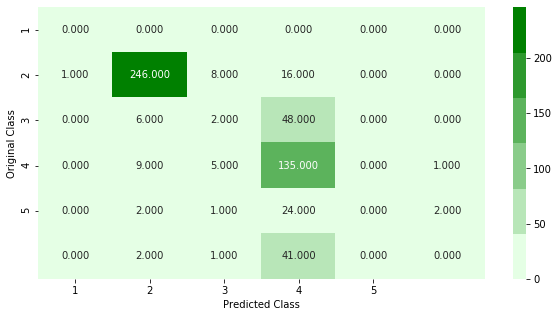

-------------------------------------------------- Precision matrix --------------------------------------------------


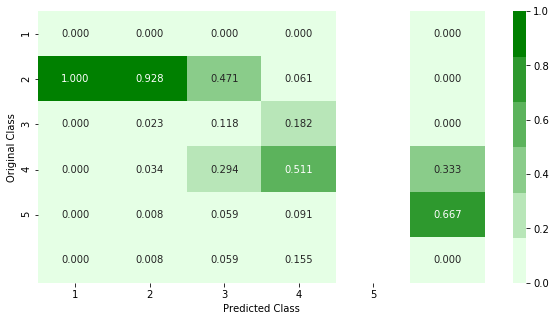

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


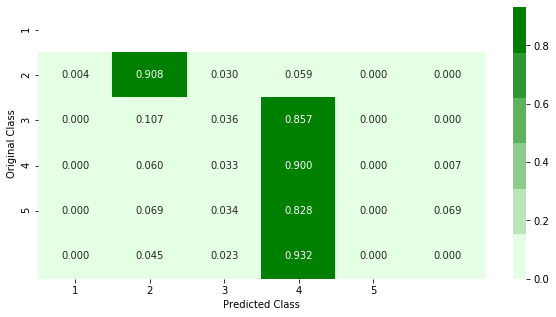

Sum of rows in precision matrix [nan  1.  1.  1.  1.  1.]


In [25]:
plot_confusion_matrix(actual_y, y_pred)

#### From the above matrices we can clearly see that the classes 1 and 3 are dominating in numbers and most of the points which belong to class 2,4,5 are mis classified to belong to calss 3

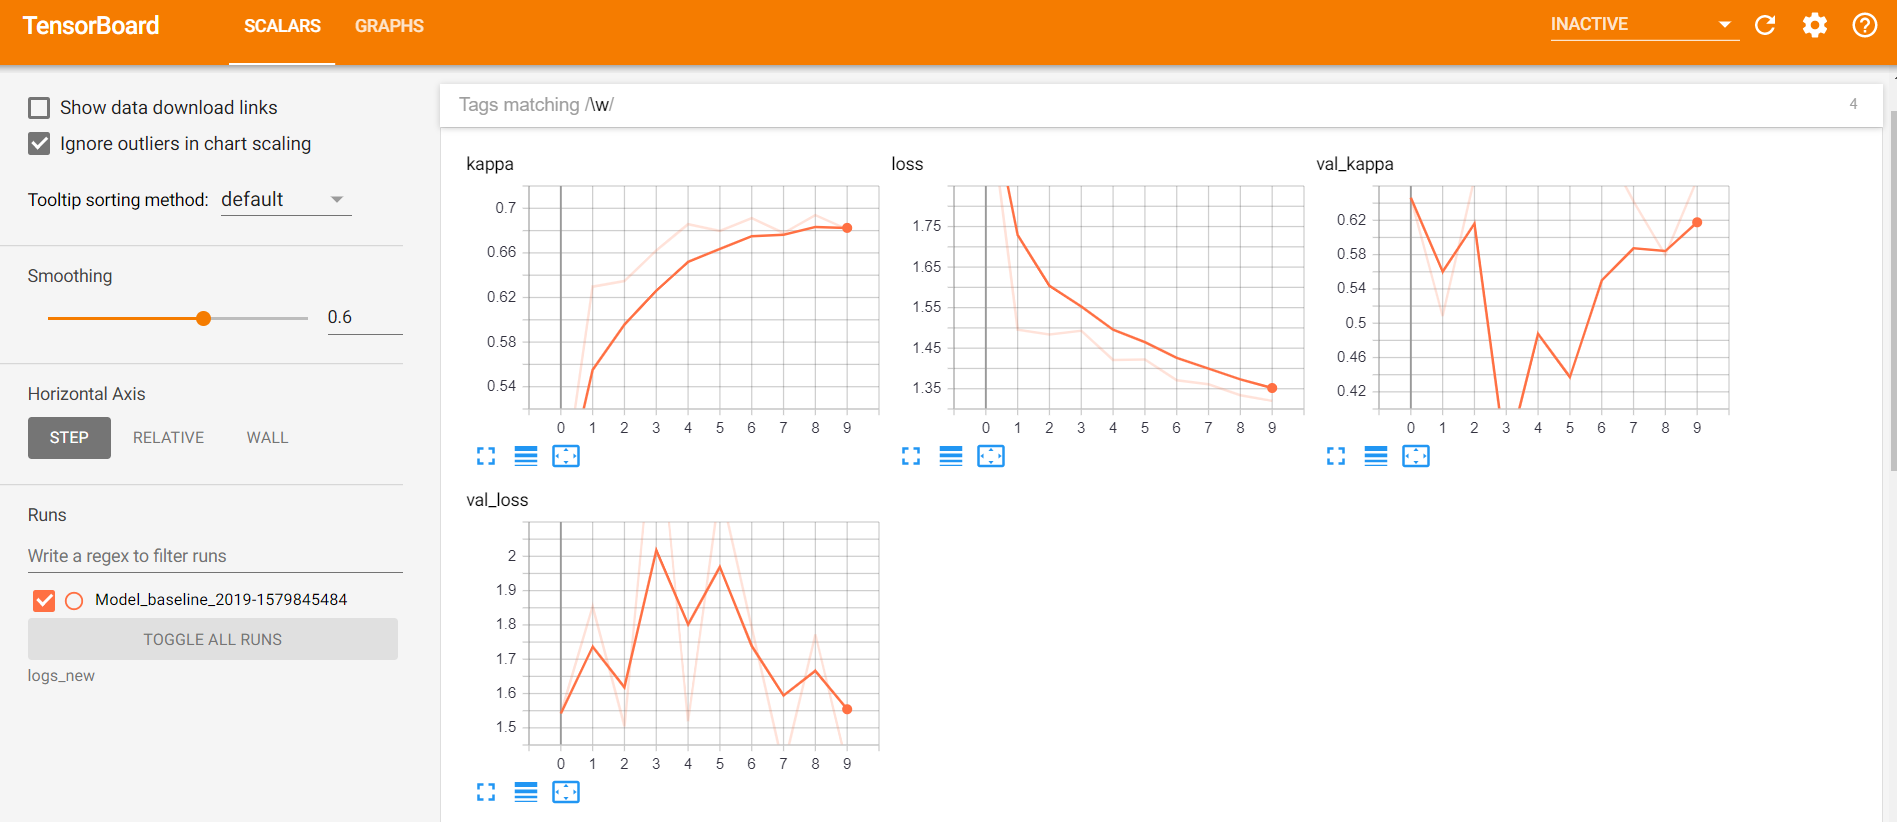

#### 2.1.2 Trying out with a deeper and wider model to see if there are any improvements.

In [28]:
Name = "Model_second_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

model_two = Sequential()
model_two.add(Conv2D(filters=16, kernel_size=3,\
                         padding='same',\
                         activation='relu', \
                         kernel_initializer = 'he_normal',\
                         input_shape=(224,224,3)))
        
model_two.add(MaxPooling2D(pool_size=2))
        
model_two.add(Conv2D(filters=32, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(Conv2D(filters=64, kernel_size=5,\
                                   activation='relu',\
                                   kernel_initializer = 'he_normal',\
                                   padding='same'))
                  
model_two.add(BatchNormalization())
                  
model_two.add(MaxPooling2D(pool_size=2))

model_two.add(Dropout(0.5))
        
model_two.add(Flatten())

model_two.add(Dense(64, kernel_initializer = 'he_normal', activation='relu'))
        
model_two.add(BatchNormalization())
        
model_two.add(Dropout(0.5))

model_two.add(Dense(5, activation='sigmoid'))

model_two.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(decay=0.001),
              metrics=[kappa])

filepath="new_kappa_weights/weights_two.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_two.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 32)      12832     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 56, 56, 64)       

In [29]:
history_two =model_two.fit(x_train, y_train,
          batch_size=16,
          epochs=30,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=2)

Train on 3112 samples, validate on 550 samples
Epoch 1/30
 - 28s - loss: 0.5612 - kappa: 0.1276 - val_loss: 0.3344 - val_kappa: 0.6812

Epoch 00001: val_kappa improved from -inf to 0.68122, saving model to new_kappa_weights/weights_two.hdf5
Epoch 2/30
 - 27s - loss: 0.3662 - kappa: 0.4228 - val_loss: 0.3139 - val_kappa: 0.6753

Epoch 00002: val_kappa did not improve from 0.68122
Epoch 3/30
 - 27s - loss: 0.2901 - kappa: 0.6132 - val_loss: 1.0948 - val_kappa: 0.1471

Epoch 00003: val_kappa did not improve from 0.68122
Epoch 4/30
 - 27s - loss: 0.2677 - kappa: 0.6490 - val_loss: 0.2364 - val_kappa: 0.6829

Epoch 00004: val_kappa improved from 0.68122 to 0.68285, saving model to new_kappa_weights/weights_two.hdf5
Epoch 5/30
 - 27s - loss: 0.2512 - kappa: 0.6654 - val_loss: 0.2178 - val_kappa: 0.6905

Epoch 00005: val_kappa improved from 0.68285 to 0.69049, saving model to new_kappa_weights/weights_two.hdf5
Epoch 6/30
 - 27s - loss: 0.2357 - kappa: 0.6886 - val_loss: 0.2250 - val_kappa: 0.

In [30]:
model_two.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_two.h5')

In [31]:
from keras.models import load_model

#model_two = load_model('new_kappa_models/model_two.h5')

In [32]:
model_two.load_weights(filepath)
score_two = model_two.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_two[0])
print('Test accuracy:', score_two[1])

Test loss: 0.2084231315146793
Test accuracy: 0.8040187003395775


In [33]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_two.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1

Number of misclassified points  27.090909090909093
-------------------------------------------------- Confusion matrix --------------------------------------------------


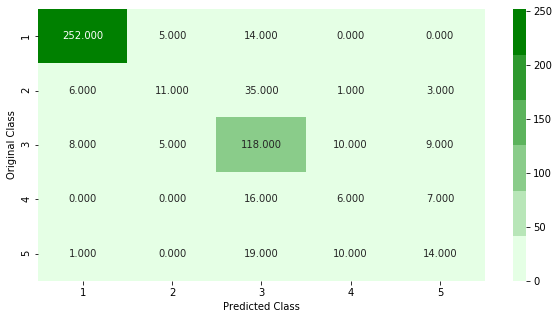

-------------------------------------------------- Precision matrix --------------------------------------------------


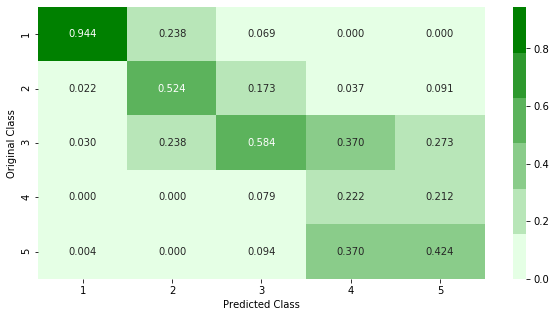

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


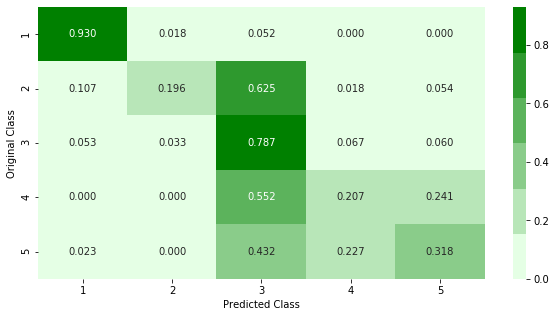

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [34]:
actual_y = y_valid.sum(axis=1) - 1 

plot_confusion_matrix(actual_y, y_pred)

In [35]:
from keras.applications import DenseNet121

Name = "Model_third_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

densenet = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_three = Sequential()
model_three.add(densenet)
model_three.add(GlobalAveragePooling2D())
model_three.add(Dropout(0.5))
model_three.add(Dense(5, activation='sigmoid'))
    
model_three.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_three.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint] + [tensorboard] 

model_three.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


#### The number of parameters used in this architectures is approximately 7Million 

In [36]:
history_three =model_three.fit(x_train, y_train,
          batch_size=8,
          epochs=30,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks_list,
          verbose=2)

Train on 3112 samples, validate on 550 samples
Epoch 1/30
 - 160s - loss: 0.3080 - kappa: 0.6188 - val_loss: 0.1638 - val_kappa: 0.8479

Epoch 00001: val_kappa improved from -inf to 0.84788, saving model to new_kappa_weights/weights_three.hdf5
Epoch 2/30
 - 136s - loss: 0.1746 - kappa: 0.8196 - val_loss: 0.1335 - val_kappa: 0.8570

Epoch 00002: val_kappa improved from 0.84788 to 0.85704, saving model to new_kappa_weights/weights_three.hdf5
Epoch 3/30
 - 137s - loss: 0.1321 - kappa: 0.8699 - val_loss: 0.1219 - val_kappa: 0.8799

Epoch 00003: val_kappa improved from 0.85704 to 0.87988, saving model to new_kappa_weights/weights_three.hdf5
Epoch 4/30
 - 137s - loss: 0.0959 - kappa: 0.9130 - val_loss: 0.1378 - val_kappa: 0.8793

Epoch 00004: val_kappa did not improve from 0.87988
Epoch 5/30
 - 137s - loss: 0.0861 - kappa: 0.9165 - val_loss: 0.1391 - val_kappa: 0.8536

Epoch 00005: val_kappa did not improve from 0.87988
Epoch 6/30
 - 137s - loss: 0.0660 - kappa: 0.9471 - val_loss: 0.1316 - v

In [37]:
model_three.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_three.h5')

#model = load_model('new_kappa_models/model_base.h5')

In [41]:
model_three.load_weights(filepath)
score_three = model_three.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_three[0])
print('Test kappa:', score_three[1])

Test loss: 0.14412418183277953
Test kappa: 0.9016966074163264


In [39]:
#converting the predicted outputs into single labels to determine the kappa score
y_pred = model_three.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Number of misclassified points  17.272727272727273
-------------------------------------------------- Confusion matrix --------------------------------------------------


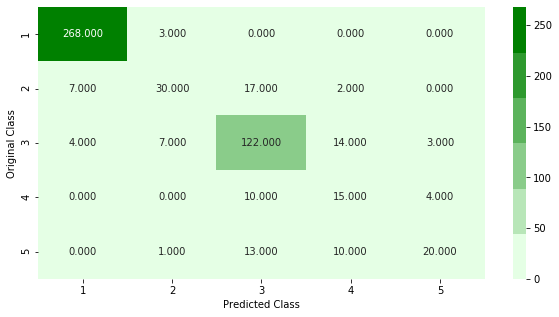

-------------------------------------------------- Precision matrix --------------------------------------------------


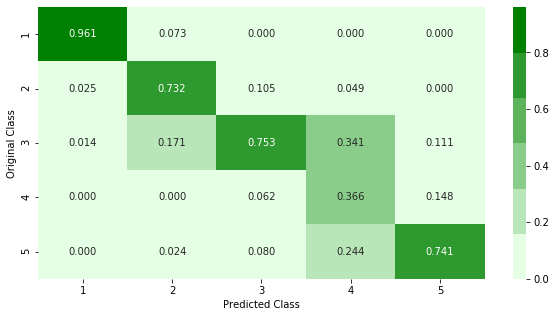

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


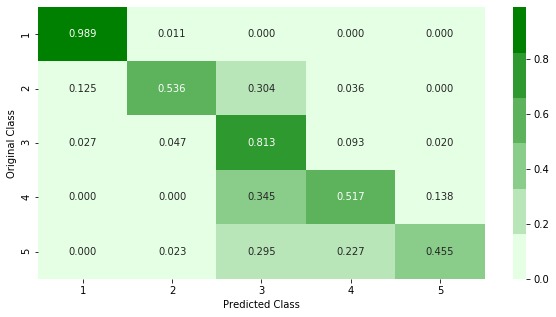

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [40]:
plot_confusion_matrix(actual_y, y_pred)

#### The performance bump in terms of Kappa score and accuracy is very high in model three, this is partially due to the architecture and also due to the size of the imagenet dataset using which we obtained the initial weights

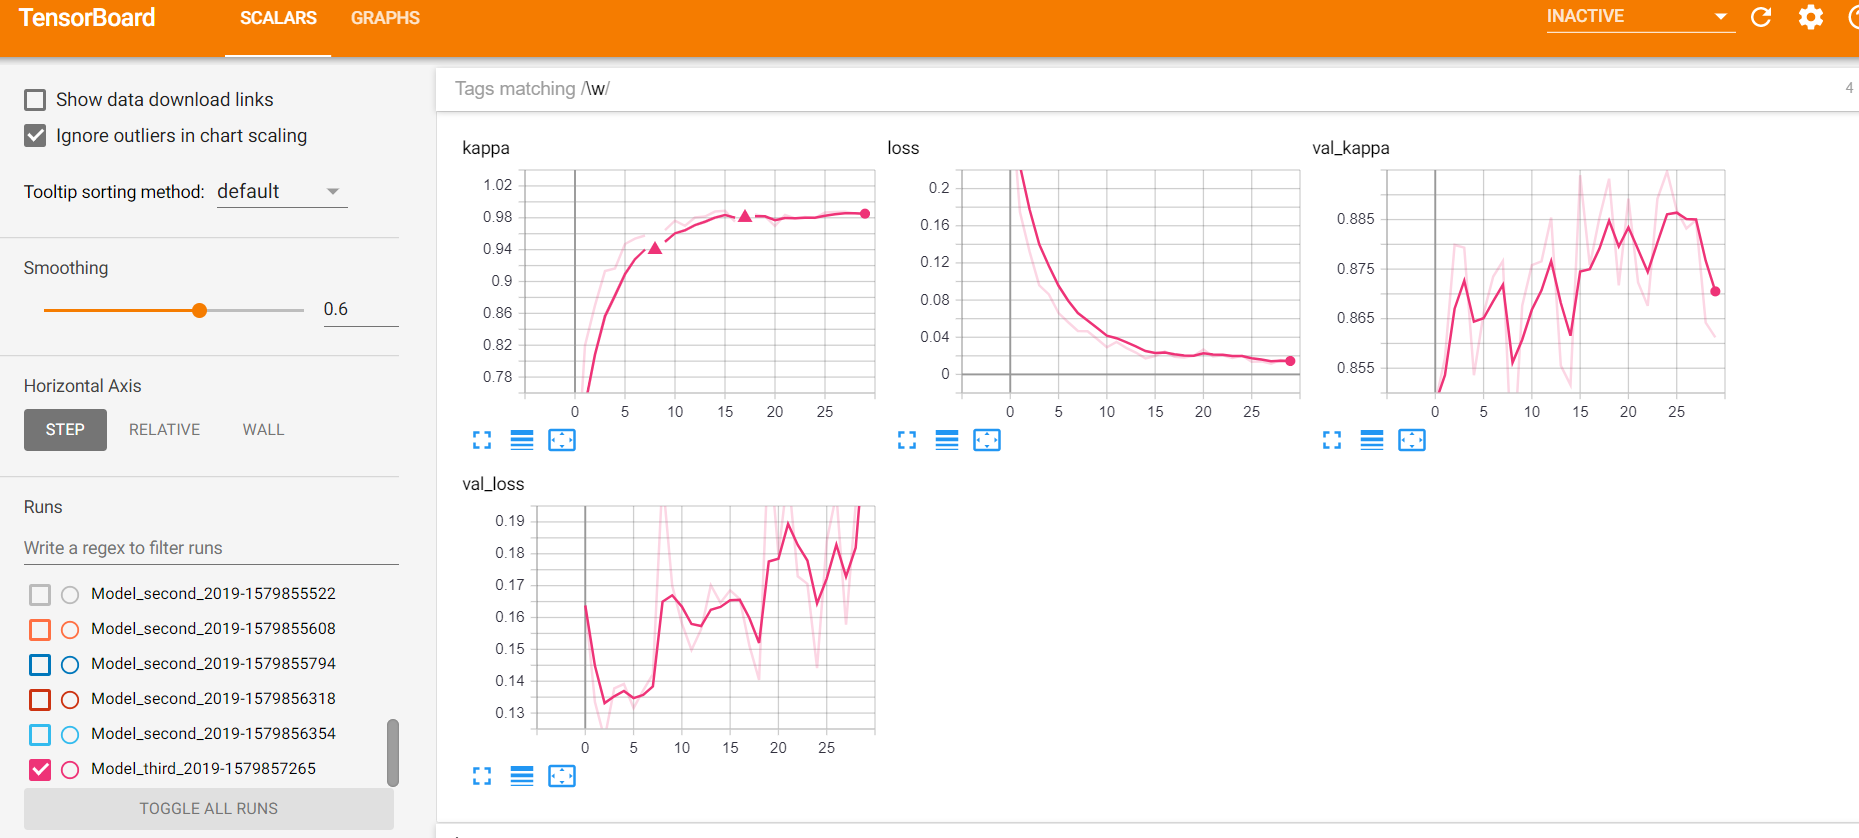

#### 2.3 Transfer Learning with Image Augmentation.

#### Data Augmentation Technique-Image Data Generator.

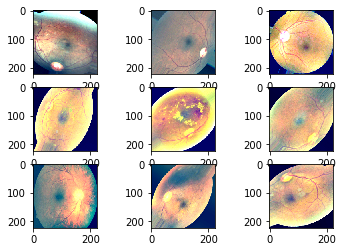

In [16]:
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_batch[i].astype('uint8'))
	# show the plot
	pyplot.show()
	break

In [18]:
from keras.applications import DenseNet121

Name = "Model_image_gen_2019-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs_new/{}'.format(Name))

densenet = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_four = Sequential()
model_four.add(densenet)
model_four.add(GlobalAveragePooling2D())
model_four.add(Dropout(0.5))
model_four.add(Dense(5, activation='sigmoid'))
    
model_four.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(lr=0.00005),
        metrics=[kappa])
    
filepath="new_kappa_weights/weights_image_gen.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint] + [tensorboard]

model_four.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
history_four =model_four.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=(x_valid, y_valid),
                    validation_steps=len(x_valid) / 8,
                    callbacks=callbacks_list)






Epoch 1/30
389/389 [==============================] - 238s 612ms/step - loss: 0.3210 - kappa: 0.5989 - val_loss: 0.1615 - val_kappa: 0.8480

Epoch 00001: val_kappa improved from -inf to 0.84801, saving model to new_kappa_weights/weights_image_gen.hdf5

Epoch 2/30
389/389 [==============================] - 154s 397ms/step - loss: 0.2007 - kappa: 0.7830 - val_loss: 0.1481 - val_kappa: 0.8362

Epoch 00002: val_kappa did not improve from 0.84801
Epoch 3/30
389/389 [==============================] - 154s 396ms/step - loss: 0.1728 - kappa: 0.8189 - val_loss: 0.1473 - val_kappa: 0.8344

Epoch 00003: val_kappa did not improve from 0.84801
Epoch 4/30
389/389 [==============================] - 154s 396ms/step - loss: 0.1497 - kappa: 0.8427 - val_loss: 0.1387 - val_kappa: 0.8395

Epoch 00004: val_kappa did not improve from 0.84801
Epoch 5/30
389/389 [==============================] - 154s 395ms/step - loss: 0.1483 - kappa: 0.8472 - val_loss: 0.1294 - val_kappa: 0.8678

Epoch 00005: val_kappa 

In [20]:
model_four.save('C:/Users/HP/Self_case_study-2/new_kappa_models/model_four.h5')
#model_four = load_model(filepath)

In [21]:
model_four.load_weights(filepath)
score_three = model_four.evaluate(x_valid, y_valid, verbose=2)
print('Test loss:', score_three[0])
print('Test kappa:', score_three[1])



y_pred = model_four.predict(x_valid,batch_size=8) > 0.5
y_pred_ordinal = np.empty(y_pred.shape, dtype=int)
y_pred_ordinal[:,4] = y_pred[:,4]

for i in range(3,-1,-1):
    y_pred_ordinal[:,i] = np.logical_or(y_pred[:,i],y_pred_ordinal[:,i+1])
    
y_pred = y_pred_ordinal.sum(axis=1)-1
actual_y = y_valid.sum(axis=1) - 1 

Test loss: 0.10946821402419697
Test accuracy: 0.9286095469648188


Number of misclassified points  14.181818181818182
-------------------------------------------------- Confusion matrix --------------------------------------------------


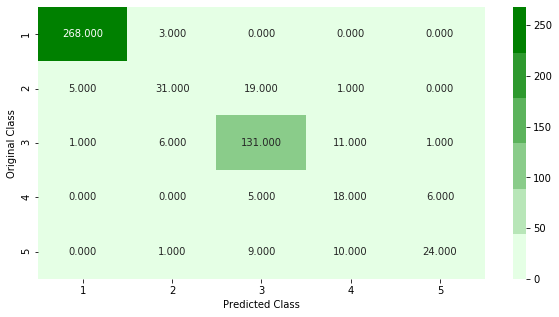

-------------------------------------------------- Precision matrix --------------------------------------------------


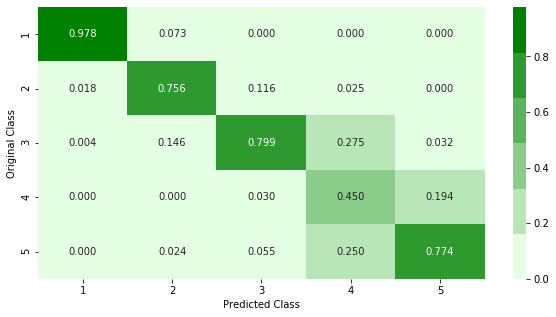

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


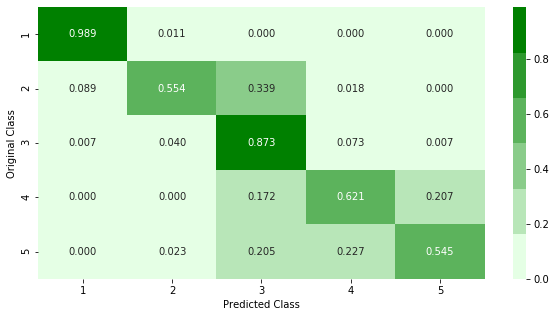

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [22]:
plot_confusion_matrix(actual_y, y_pred)

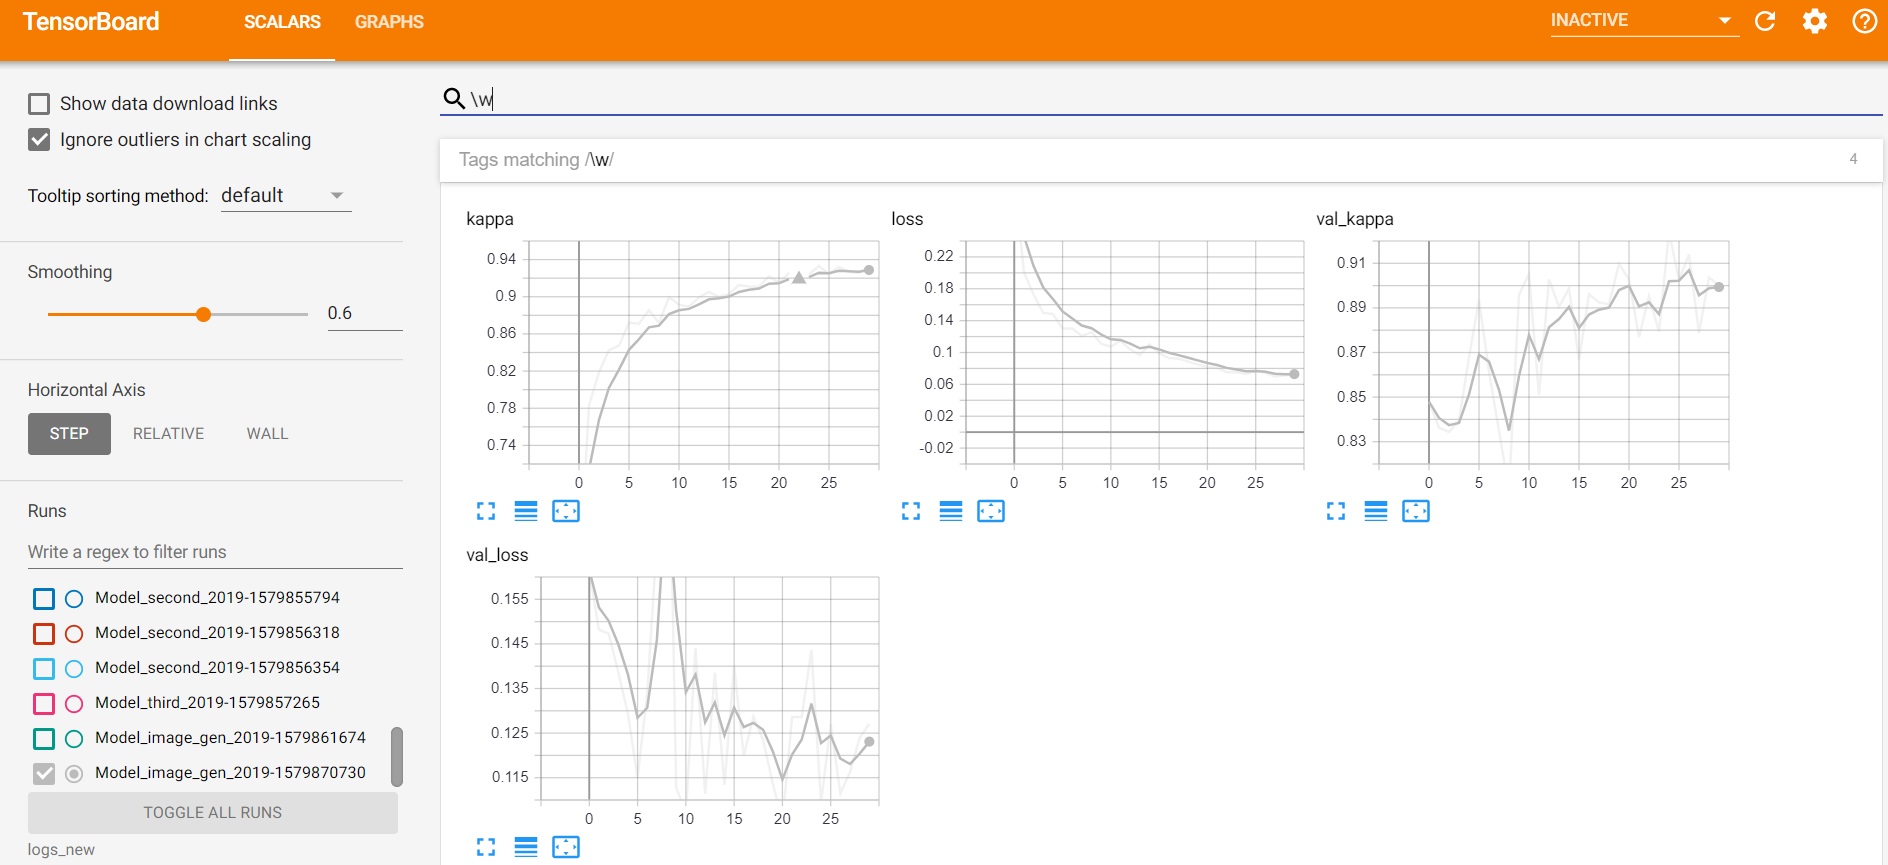

#### From the above plots we can see that the Model uisng Image data Genaretor performs better as it introduces variation in the inputs which is crucial in sitations where we have less data to train on. 

#### 2.4 Utilizing External Data.

#### A similar problem to our's was solved in an earlier kaggle competetion hosted in 2015, From which we can leverage the data to train our models on a larger dataset and possibly improve the performance.

The dataset is acquired from https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized
where the images are available in .jpeg format as opposed to .png format of the otiginal so as to reduce space consumption.

#### 2.4.1 Loading 2015  Data

In [9]:
print(os.listdir('D:/Blindness Detection//2015_data'))

['resized test 15.zip', 'resized train 15.zip', 'testLabels15.csv', 'test_images', 'trainLabels15.csv', 'train_images', 'train_images_preprocessed', 'train_images_preprocessed[1, 0, 0, 0, 0]', 'train_images_preprocessed[1, 1, 0, 0, 0]', 'train_images_preprocessed[1, 1, 1, 0, 0]', 'train_images_preprocessed[1, 1, 1, 1, 0]', 'train_images_preprocessed[1, 1, 1, 1, 1]', 'train_images_preprocessed_backup']


In [10]:
df_2015_train = pd.read_csv('D:/Blindness Detection/2015_data//trainLabels15.csv')
df_2015_test = pd.read_csv('D:/Blindness Detection/2015_data//testLabels15.csv')

df_2015_train.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [11]:
df_2015_train.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)
df_2015_test.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)

df_2015_train.head()

id_code  diagnosis
0   10_left          0
1  10_right          0
2   13_left          0
3  13_right          0
4   15_left          1

--------------------------------------------------------------------------------


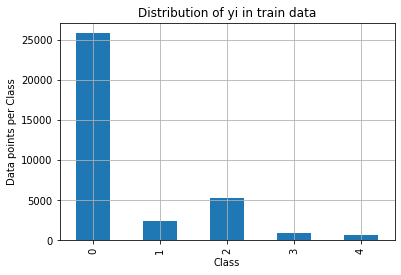

Number of data points in class 1 : 25810 ( 73.478 %)
Number of data points in class 3 : 5292 ( 15.066 %)
Number of data points in class 2 : 2443 ( 6.955 %)
Number of data points in class 4 : 873 ( 2.485 %)
Number of data points in class 5 : 708 ( 2.016 %)
--------------------------------------------------------------------------------


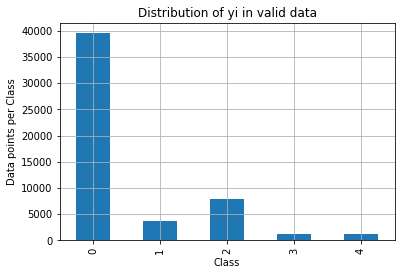

Number of data points in class 1 : 39533 ( 73.789 %)
Number of data points in class 3 : 7861 ( 14.673 %)
Number of data points in class 2 : 3762 ( 7.022 %)
Number of data points in class 4 : 1214 ( 2.266 %)
Number of data points in class 5 : 1206 ( 2.251 %)


In [12]:
plot_distribution(df=df_2015_train, labels=df_2015_train['diagnosis'], t_cv_te='train')
plot_distribution(df=df_2015_test, labels=df_2015_test['diagnosis'], t_cv_te='valid')

In [13]:
#Converting the output variable into ordinals

y_train = pd.get_dummies(df_2015_train['diagnosis']).values
y_test = pd.get_dummies(df_2015_test['diagnosis']).values

y_train=ordinal_regression(y_train)
y_test=ordinal_regression(y_test)

df_2015_train['diagnosis']  = y_train.tolist()
df_2015_test['diagnosis']  = y_test.tolist()

df_2015_train.head()

(35126, 5)
(53576, 5)


id_code        diagnosis
0   10_left  [1, 0, 0, 0, 0]
1  10_right  [1, 0, 0, 0, 0]
2   13_left  [1, 0, 0, 0, 0]
3  13_right  [1, 0, 0, 0, 0]
4   15_left  [1, 1, 0, 0, 0]

#### 2.4.2 Preprocessing 2015 Images

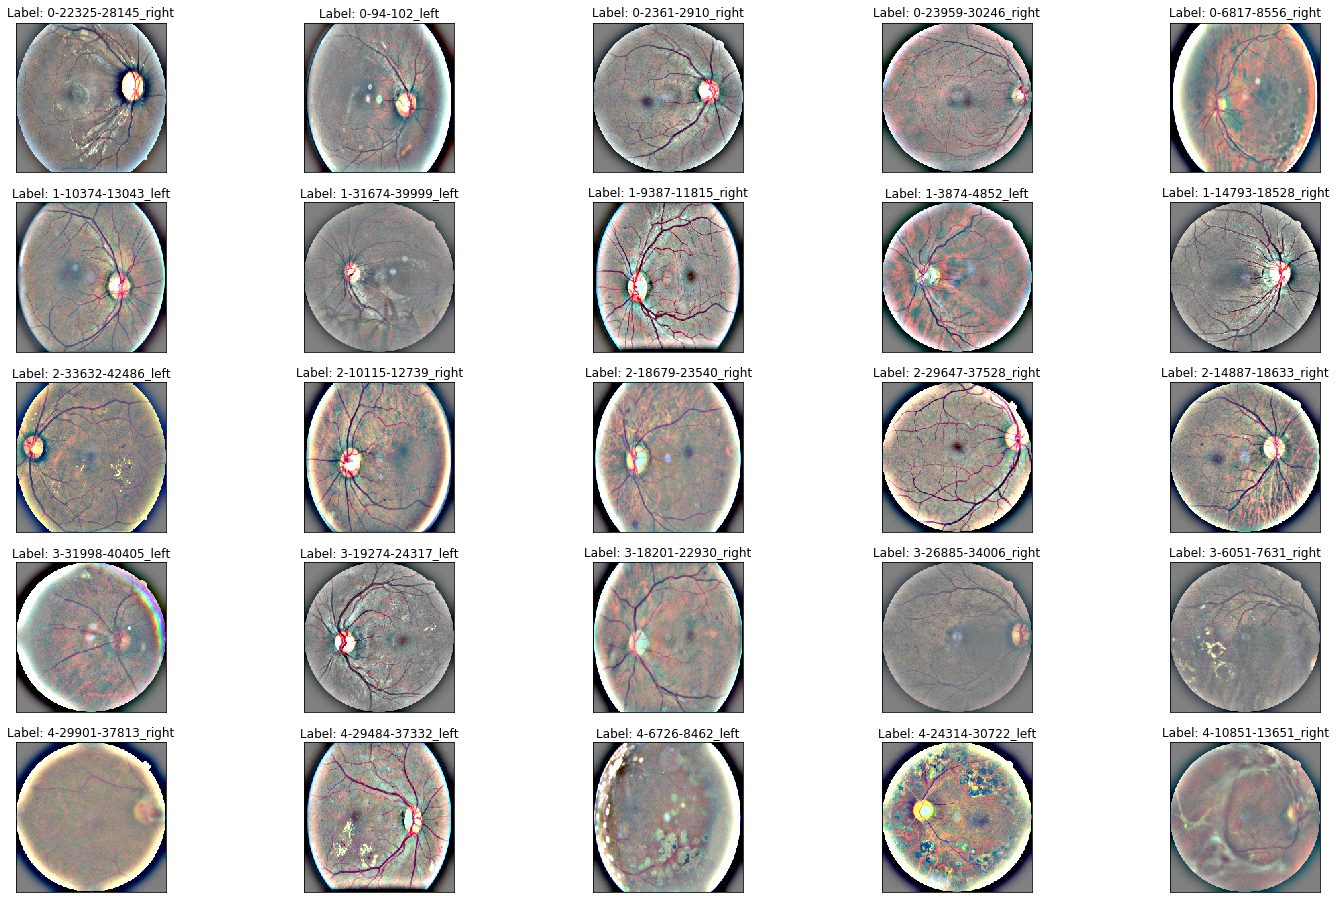

In [28]:
image_preprocessing_1(df_2015_train,df_2015_train['diagnosis'],ben=True,\
                      sub_dir = '2015_data/train_images',sigmaX=10, ext='.jpg')